# Imports

In [1]:
%matplotlib inline

import random
import math
import numpy as np
from axelrod import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from JSAnimation.IPython_display import display_animation

from matplotlib import animation, rc
from IPython.display import HTML

# Agent class

In [2]:
class Agent():
    def __init__(self, position, strategy, score=-1):
        self.position = position
        self.strategy = strategy
        self.score = score
    def copy(self):
        return Agent(self.position, self.strategy, self.score)

# Strategies

In [3]:
STRATEGIES = [
    ('Defector', Defector()), 
    ('Cooperator', Cooperator()),
    ('Tit For Tat', TitForTat()),
    ('GTFT: 0.33', GTFT()),
]
STRATEGY_COLORS = ["#e74c3c", "#2ecc71", "#2980b9", "#03A9F4", "#ffffff"]#34495e
# Red Green Blue Cyan Background

# Filter functions

In [51]:
def createKochCurve(matrix, iterationsLeft):
    newMatrix = np.zeros((matrix.shape[0] * 3, matrix.shape[1] * 3))
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j] == True:
                fillMatrix(newMatrix, i*3, j*3)
    if iterationsLeft == 0:
        return newMatrix
    else:
        return createKochCurve(newMatrix, iterationsLeft - 1)
def fillMatrix(matrix, top, left):
    matrix[top, left] = True
    matrix[top, left + 2] = True
    matrix[top + 1, left + 1] = True
    matrix[top + 2, left] = True
    matrix[top + 2, left + 2] = True

circleFilterFunction = lambda coordinate, radius: (coordinate[0])**2 + (coordinate[1])**2 <= radius**2

rectangleFilterFunction = lambda coordinate: True

fiveCircleFilterFunction = lambda coordinate: circleFilterFunction(coordinate, 4)

triangleFilterFuncion = lambda coordinate: ((coordinate[1] > 0) and
                                            (coordinate[1] < coordinate[0]) and
                                            (coordinate[1] < -coordinate[0] + 15))

waveFilterFunction = lambda coordinate: coordinate[1] < math.sin(coordinate[0] / 3) * 7 + 8
waveBiggerGapFilterFunction = lambda coordinate: coordinate[1] < math.sin(coordinate[0] / 2) * 8 + 11

donutFilterFunction = lambda coordinate: circleFilterFunction(coordinate, 6) and not circleFilterFunction(coordinate, 3)

squareHolesFilterFunction = lambda coordinate: not (coordinate[0] % 3 == 0 and coordinate[1] % 3 == 0)
shortLinesSquareHolesFilterFunction = lambda coordinate: not (not coordinate[0] % 3 == 0 and not coordinate[1] % 3 == 0)

kochCurve = createKochCurve(np.ones((1, 1)), 2)

kochCurveFilterFunction = lambda coordinate: kochCurve[coordinate[0], coordinate[1]]

lineFilterFunction = lambda coordinate: coordinate[0] == coordinate[1]

# Testing createKochCurve
#print(createKochCurve(np.ones((1, 1)), 1))

# getAvailablePoints

In [5]:
# @doc getAvailablePoints
# returns the list of coordinates of every agent
# @param   {Vector}   leftBottomCorner: defines the start of the environment
# @param   {Vector}   rightTopCorner: defines the end of the environment
# @param   {Function} filterFunction: defines the shape of the environment
# @returns {[Vector]} points: coordinates of agents
def getAvailablePoints(leftBottomCorner, rightTopCorner, filterfunction):
    points = []
    for xCoordinate in range(leftBottomCorner[0], rightTopCorner[0] + 1):
        for yCoordinate in range(leftBottomCorner[1], rightTopCorner[1] + 1):
            if filterfunction((xCoordinate, yCoordinate)):
                points.append([xCoordinate, yCoordinate])
    return points

# Test that the function works by passing a circle filter function
#print(getAvailablePoints([-2, -2], [2, 2], unitCircleFilterFunction))

# populateGrid

In [6]:
# @doc populateGrid
# creates agents from list of positions
# @param   {[Vector]} individuals: list of coordinates
# @returns {[Agent]}  population
def populateGrid(individuals):
    population = []
    for i in range(len(individuals)):
        index = random.randint(0, 3)
        population.append(Agent(position = individuals[i], strategy = STRATEGIES[index][1]))
    return population

# Testing
print(populateGrid([[0, 0], [1, 1], [2, 2]]))
print(populateGrid([[0, 0], [1, 1], [2, 2]])[0].position)
print(populateGrid([[0, 0], [1, 1], [2, 2]])[2].strategy)

[<__main__.Agent object at 0x00000237AF18A588>, <__main__.Agent object at 0x00000237AF18A630>, <__main__.Agent object at 0x00000237AF18A668>]
[0, 0]
Cooperator


# newGeneration

In [21]:
# @doc getneighbors
# returns neighborhood of the given agent
# @param   {[Agents]} individuals: population
# @param   {Vector}   position
# @returns {[Agents]} neighbors
def getNeighbors(agents, position):
    neighbors = []
    (x,y) = position
    possibilities = [[x-1, y-1], [x, y-1], [x+1, y-1], 
                       [x-1, y],           [x+1, y], 
                     [x-1, y+1], [x, y+1], [x+1, y+1]]
    for possibility in possibilities:
        # Check if possibility is inside individuals
        agentEqualsPossibility = lambda agent: agent.position == possibility
        equalAgentsList = list(filter(agentEqualsPossibility, agents))
        if(not len(equalAgentsList) == 0):
            neighbors.append(equalAgentsList[0])
    return neighbors

# Testing
points = getAvailablePoints((0, 0), (1, 1), rectangleFilterFunction)
individuals = populateGrid(points)
neighborhood = getNeighbors(individuals, individuals[0].position)
for i in neighborhood:
    print("neighbor: ", i.position)
    
# @doc getStrategyByName
def getStrategyByName(strategy):
    for i in STRATEGIES:
        if strategy == i[0]:
            return i[1]

# @doc newGeneration
# Calculates the new state of the population
# @param   {[Agents]} currentPopulation
# @param   {Function}   evaluationStrategy:
#                         - globalEvaluationStrategy (default):
#                               calculate every fitness and then see the best strategy for each cell
#                         - localEvaluationStrategy:
#                               foreach cell create a neighborhood tournament and choose the winner
# @returns {[Agents]} newPopulation
def newGeneration(individuals, evaluationStrategy):
    return evaluationStrategy(individuals)

# Testing newGeneration
print("newGenerationTesting")
print("currentPopulation: ", list(map(lambda individual: (individual.position, individual.strategy), individuals)))
newPopulation = newGeneration(individuals, globalEvaluationStrategy)
print("newPopulation: ", list(map(lambda individual: (individual.position, individual.strategy), newPopulation)))

neighbor:  [1, 0]
neighbor:  [0, 1]
neighbor:  [1, 1]
newGenerationTesting
currentPopulation:  [([0, 0], Tit For Tat), ([0, 1], Tit For Tat), ([1, 0], GTFT: 0.33), ([1, 1], Defector)]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 269.01it/s]


2.3 [2.1666666666666665]
2.3 [1.8]
newPopulation:  [([0, 0], Tit For Tat), ([0, 1], Tit For Tat), ([1, 0], Tit For Tat), ([1, 1], Tit For Tat)]


# Evaluation Strategies

In [20]:
def localEvaluationStrategy(individuals):
    newIndividuals = []
    for individual in individuals:
        tournamentResults = playTournamentWithNeighbors(individuals, individual)
        summary = tournamentResults.summarise()
        for player in summary:
            if(player[0] == 0):
                newIndividuals.append(Agent(individual.position,getStrategyByName(player[1])))
                break
    return newIndividuals

def globalEvaluationStrategy(population):
    newPopulation = []
    populationWithScores = calculateScores(population)
    
    for agent in populationWithScores:
        neighbors = getNeighbors(populationWithScores, agent.position)
        bestAgent = max(neighbors + [agent], key = lambda individual: individual.score)
        newAgent = agent.copy()
        if bestAgent.score[0] > agent.score:
            newAgent.strategy = bestAgent.strategy
            print(bestAgent.score[0], agent.score)
        newPopulation.append(newAgent)
    
    return newPopulation

# @doc calculateScores
# returns a population with updated scores
# @param   {[Agent]} population
# @returns {[Agent]} populationWithScores
def calculateScores(population):
    populationWithScores = []
    for agent in population:
        tournamentResults = playTournamentWithNeighbors(population, agent)
        newAgent = agent.copy()
        newAgent.score = tournamentResults.normalised_scores[0]
        populationWithScores.append(newAgent)
    return populationWithScores

# @doc playTournamentWithNeighbors
# plays a tournament between an agent and its neighbors
# in a one vs all fashion
# @param   {[Agent]}        population
# @param   {Agent}          agent
# @returns {axelrod.result} result
def playTournamentWithNeighbors(population, agent):
    neighbors = getNeighbors(population, agent.position)
    neighborsStrategies = [individual.strategy for individual in neighbors]
    edges = []
    for i in range(len(neighbors)):
        edges.append((0,i+1))
    players = [agent.strategy] + neighborsStrategies
    return Tournament(players, edges = edges, turns = 10, repetitions = 1).play()
        

# graphPopulation

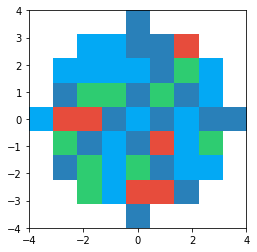

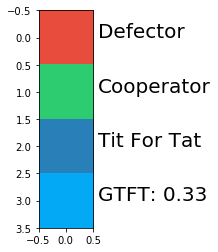

In [59]:
# @doc getStrategyColor
# returns a color for a strategy
# @param {axl.Strategy} strategy
# @returns {Integer} color
def getStrategyColor(strategy):
    for i in range(len(STRATEGIES)):
        if(STRATEGIES[i][0] == str(strategy)):
            return i

# @doc graphPopulation
# uses matplotlib to graph the population
# @param {[Agent]} population
def graphPopulation(population): # TODO: fix shapes that are not rectangles :)
    positions = [agent.position for agent in population]
    xPositions = [position[0] for position in positions]
    yPositions = [position[1] for position in positions]
    minXPosition = min(xPositions)
    maxXPosition = max(xPositions)
    minYPosition = min(yPositions)
    maxYPosition = max(yPositions)
    strategiesMatrix = np.zeros((maxXPosition - minXPosition + 1, maxYPosition - minYPosition + 1))
    for i in range(minXPosition , maxXPosition + 1):
        for j in range(minYPosition, maxYPosition + 1):
            if not [i, j] in positions:
                strategiesMatrix[i - minXPosition, j - minYPosition] = 4
            else:
                strategiesMatrix[i - minXPosition, j - minYPosition] = getStrategyColor(population[positions.index([i, j])].strategy)

    cmap = colors.ListedColormap(STRATEGY_COLORS)
    bounds = [-1,0.5,1.5,2.5,3.5, 4.5]
    norm = colors.BoundaryNorm(bounds,cmap.N)    
    plt.imshow(strategiesMatrix.T,extent=(minXPosition, maxXPosition, minYPosition, maxYPosition),cmap=cmap,norm=norm)
    plt.show()
    return strategiesMatrix.T
    
def drawReferences():
    
    cmap = colors.ListedColormap(STRATEGY_COLORS)
    bounds = [-1,0.5,1.5,2.5,3.5, 4.5]
    norm = colors.BoundaryNorm(bounds,cmap.N)    
    
    img = [[0],[1],[2],[3]]
    plt.imshow(img,cmap = cmap,norm = norm)
    font = 20
    plt.text(0.6,0,STRATEGIES[0][0]).set_fontsize(font)
    plt.text(0.6,1,STRATEGIES[1][0]).set_fontsize(font)
    plt.text(0.6,2,STRATEGIES[2][0]).set_fontsize(font)
    plt.text(0.6,3,STRATEGIES[3][0]).set_fontsize(font)
    plt.show()


# Testing graphPopulation
points = getAvailablePoints((-10, -10), (15, 15), fiveCircleFilterFunction)
population = populateGrid(points)
graphPopulation(population)
drawReferences()

# Animation Function

Making animation: 1 %
Making animation: 3 %
Making animation: 5 %
Making animation: 7 %
Making animation: 9 %



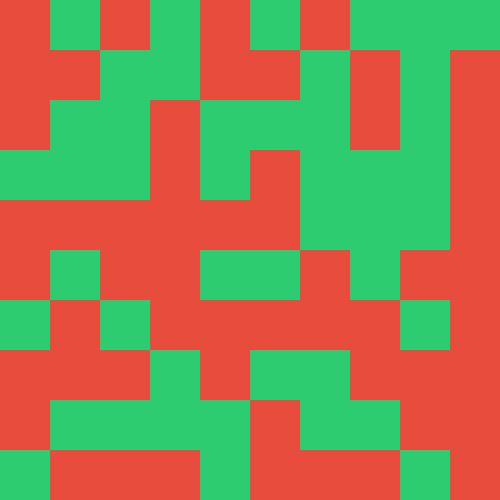
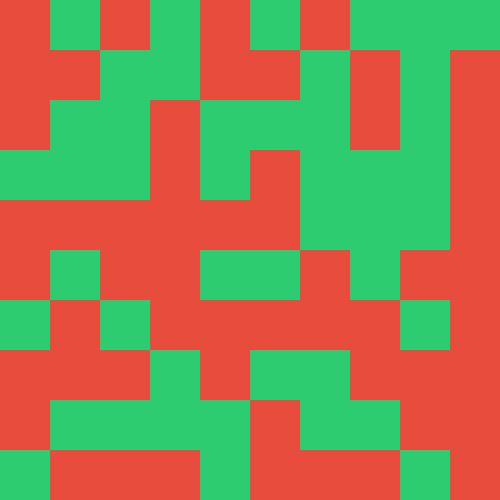
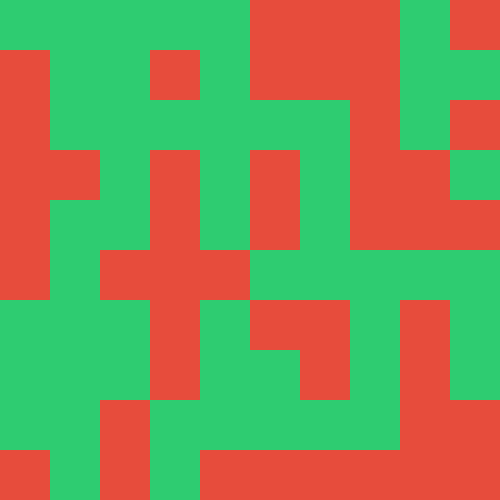
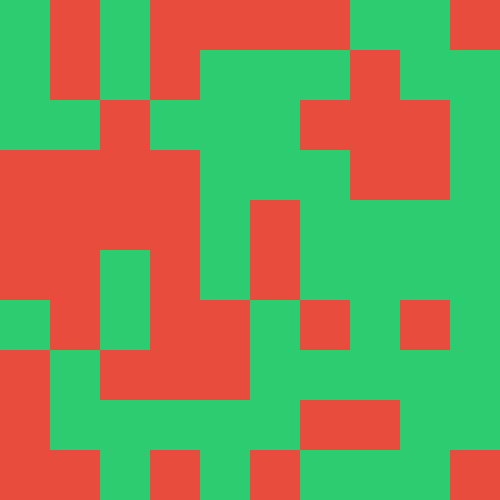
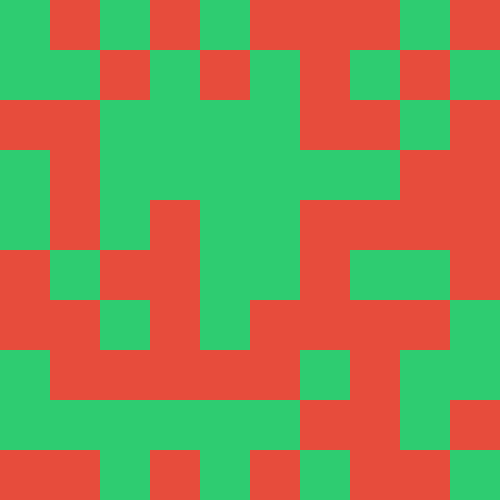

In [10]:
def makeAnimation(array,frames):
    size=(100,100)
    num_colors = 3
    A = array
    X = array[0]
    dpi = 10.
    factor = 50

    figsize = (X.shape[1] * factor / dpi , X.shape[0] * factor / dpi  )
    
    cmap = colors.ListedColormap(STRATEGY_COLORS)
    bounds = [-1,0.5,1.5,2.5,3.5, 4.5]
    norm = colors.BoundaryNorm(bounds,cmap.N)  
    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    img = plt.imshow(X,cmap = cmap,norm=norm)

    def init():
        img.set_data(np.zeros(size))
        return (img,)

    # animation function.  This is called sequentially
    def animate(i):
        img.set_data(animate.X)
        print('Making animation:', round((i/len(A))*100)+1,'%' )
        animate.X = A[i]
        return (img,)

    animate.X = X


    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=frames, interval=20, blit=True)
    return anim

# Testing makeAnimation
A = [np.random.rand(10,10) for i in range(50)]

anim = makeAnimation(A,5)
display_animation(anim)

# getAverageNeighbors

In [60]:
def getAverageNeighbors(filterFunction):
    points = getAvailablePoints((-10, -10), (15, 15), filterFunction)
    population = populateGrid(points) # appends the strategies
    
    totalNeighbors = 0
    
    for agent in population:
        neighbors = getNeighbors(population, agent.position)
        totalNeighbors += len(neighbors)
    return totalNeighbors / len(points)

print(getAverageNeighbors(fiveCircleFilterFunction))

6.36734693877551


# Main function

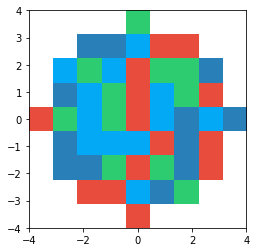

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2008.77it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 272.83it/s]


2.65 [2.6000000000000001]
3.0 [2.6499999999999999]
3.0 [2.5]
3.0 [2.6499999999999999]
3.0 [2.4750000000000001]
3.0 [2.3999999999999999]
2.475 [2.2000000000000002]
3.0 [2.6499999999999999]
3.1 [2.3999999999999999]
3.1 [1.875]
3.1 [2.25]
3.0 [2.3875000000000002]
3.0 [1.875]
2.6 [2.0]
3.2 [2.0]
3.2 [2.2166666666666663]
3.2 [2.5]
3.1 [2.6499999999999999]
2.65 [2.0999999999999996]
2.6 [1.8333333333333333]
2.3 [1.8]
3.2 [1.5]
3.1 [2.1124999999999998]
3.1 [2.125]
2.65 [2.0]
2.6 [2.25]
2.6 [2.3000000000000003]
3.2 [3.1000000000000001]
3.2 [1.7142857142857142]
2.73333333333 [2.625]
2.73333333333 [2.2124999999999999]
2.25 [2.2124999999999999]
2.3 [2.1000000000000001]
2.3 [2.25]
3.1 [1.9500000000000002]
2.73333333333 [2.1666666666666665]
2.2125 [1.4666666666666668]
2.25 [2.2000000000000002]
2.73333333333 [1.5999999999999999]


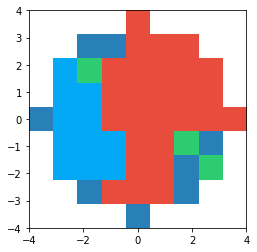

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3007.03it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 272.82it/s]


3.0 [2.4750000000000001]
3.0 [2.1428571428571428]
3.0 [2.1124999999999998]
3.0 [2.3624999999999998]
3.0 [2.7250000000000001]
3.0 [2.6714285714285713]
3.0 [2.4750000000000001]
2.475 [1.5999999999999999]
2.475 [1.7000000000000002]
2.3625 [1.8499999999999999]
2.725 [1.7]
2.725 [1.7749999999999999]
2.725 [1.75]
2.67142857143 [1.6666666666666667]
1.6 [1.1333333333333333]
1.7 [1.0666666666666667]
1.85 [1.05]
1.85 [1.0]
1.85 [1.2]
1.775 [1.2999999999999998]
1.775 [1.3500000000000001]
1.75 [1.2666666666666666]
1.66666666667 [0.90000000000000002]
1.13333333333 [1.0]
1.06666666667 [1.0]
1.55 [1.0]
1.55 [1.5]
2.1 [1.55]
2.1 [1.6000000000000001]
2.1 [1.2000000000000002]
1.73333333333 [1.0]
1.95 [1.55]
3.0 [1.125]
3.0 [2.1000000000000001]
3.0 [1.9500000000000002]
1.73333333333 [1.0]
1.95 [1.7333333333333334]
3.0 [1.95]
1.95 [1.1333333333333333]


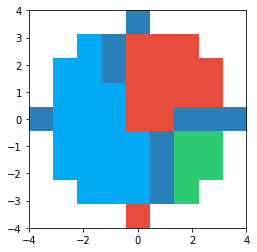

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3005.95it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 269.33it/s]


3.0 [2.3000000000000003]
3.0 [2.2124999999999999]
3.0 [2.0750000000000002]
3.0 [2.4124999999999996]
3.0 [2.7000000000000002]
3.0 [2.6166666666666667]
2.3 [1.5999999999999999]
2.3 [1.2]
2.3 [1.2]
2.4125 [1.3500000000000001]
2.7 [1.9500000000000002]
3.0 [2.3999999999999999]
3.0 [2.6000000000000001]
2.65 [1.8]
1.6 [1.0666666666666667]
1.35 [1.0]
1.95 [1.05]
2.625 [1.8]
3.0 [2.4750000000000001]
3.0 [2.6499999999999999]
1.06666666667 [1.0]
1.2 [1.0]
2.3 [1.1000000000000001]
3.0 [1.95]
3.0 [2.625]
1.2 [1.0]
2.3 [1.2000000000000002]
3.0 [2.3000000000000003]
3.0 [2.3000000000000003]


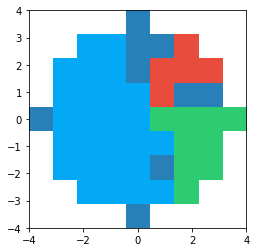

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2915.07it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 265.92it/s]


3.0 [2.6499999999999999]
3.0 [2.4750000000000001]
3.0 [2.3624999999999998]
3.0 [2.6749999999999998]
3.0 [1.9500000000000002]
2.65 [1.5]
2.675 [2.3499999999999996]
3.0 [2.625]
1.95 [1.1000000000000001]
2.35 [1.1714285714285715]
3.0 [1.95]
3.0 [2.625]
2.3 [1.2]
3.0 [2.3000000000000003]


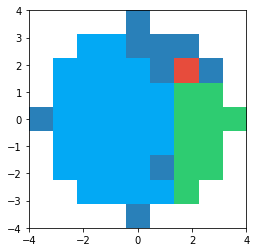

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3004.52it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 272.82it/s]


3.0 [2.6499999999999999]
3.0 [2.7374999999999998]
3.0 [2.7000000000000002]
2.7375 [2.4750000000000001]
2.7375 [2.4857142857142853]
3.0 [2.625]
2.625 [2.4750000000000001]
3.0 [2.5]


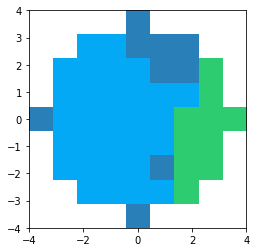

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3111.12it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 272.82it/s]


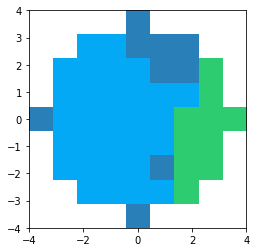

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2038.38it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 273.02it/s]


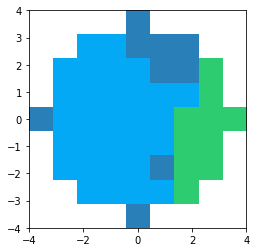

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2919.81it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 228.37it/s]


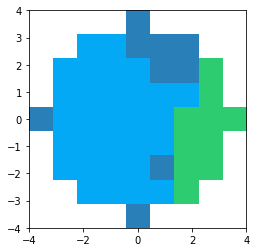

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2949.58it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 256.37it/s]


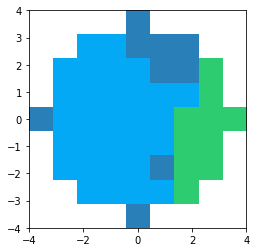

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3003.44it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 262.78it/s]


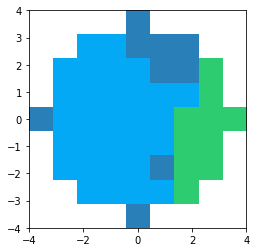

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3004.52it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 266.10it/s]


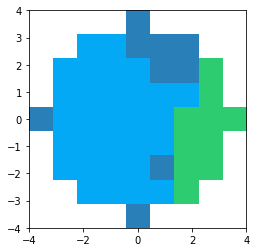

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2041.85it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 272.83it/s]


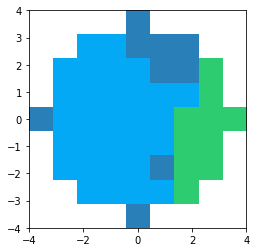

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2920.49it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 272.81it/s]


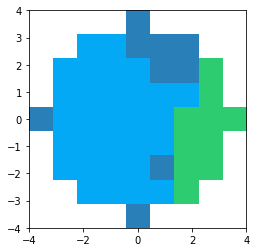

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2912.71it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 256.56it/s]


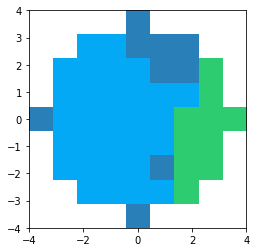

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2003.01it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 266.10it/s]


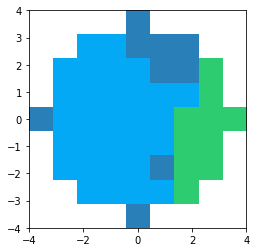

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2948.20it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 265.93it/s]


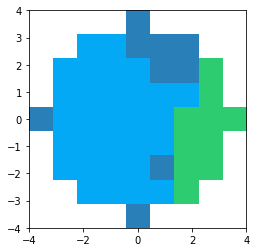

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2928.64it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 273.02it/s]


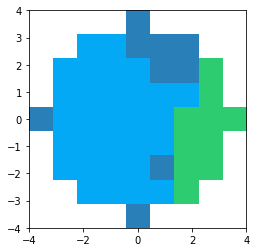

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2003.49it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 269.50it/s]


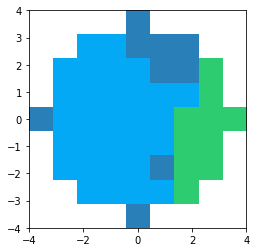

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2919.81it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 256.37it/s]


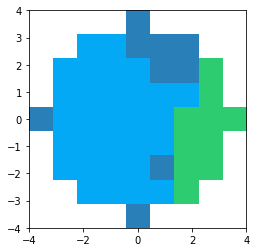

Playing matches: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2911.70it/s]


Finishing: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 271.99it/s]


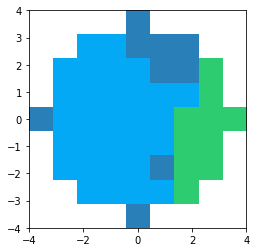

Making animation: 1 %
Making animation: 6 %
Making animation: 11 %
Making animation: 16 %
Making animation: 21 %
Making animation: 26 %
Making animation: 31 %
Making animation: 36 %
Making animation: 41 %
Making animation: 46 %
Making animation: 51 %
Making animation: 56 %
Making animation: 61 %
Making animation: 66 %
Making animation: 71 %
Making animation: 76 %
Making animation: 81 %
Making animation: 86 %
Making animation: 91 %
Making animation: 96 %



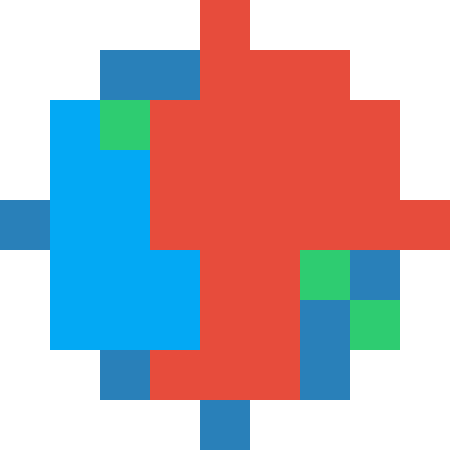
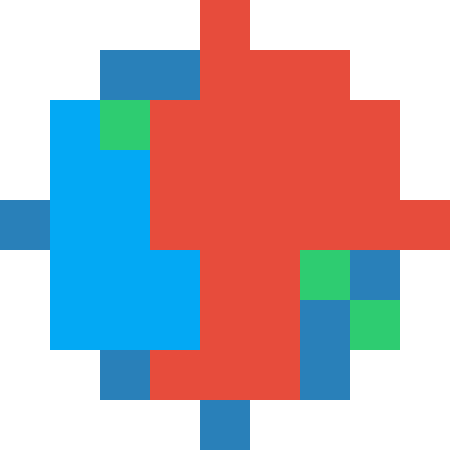
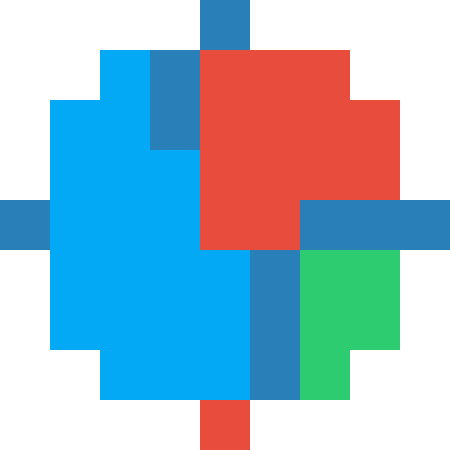
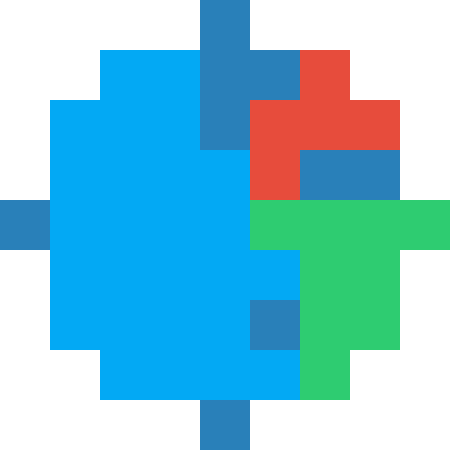
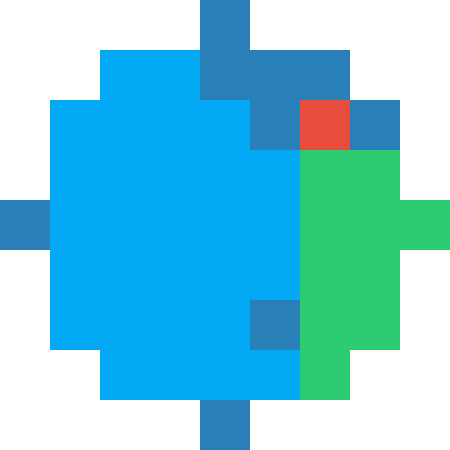
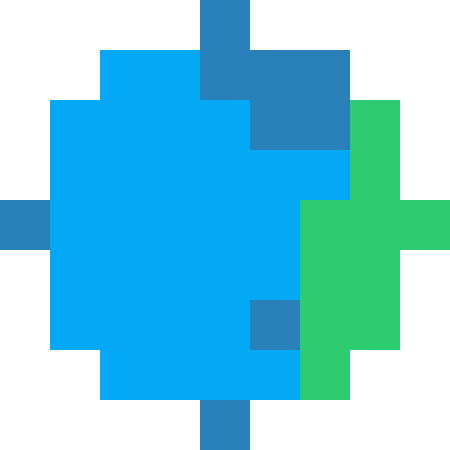
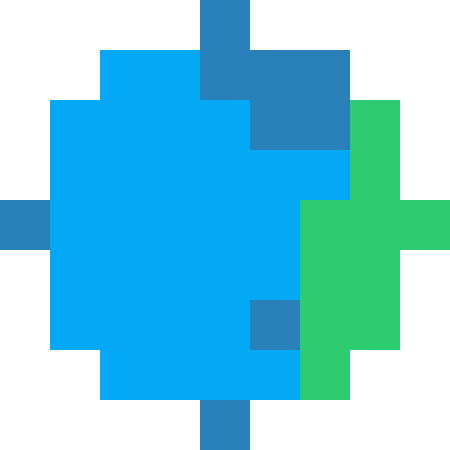
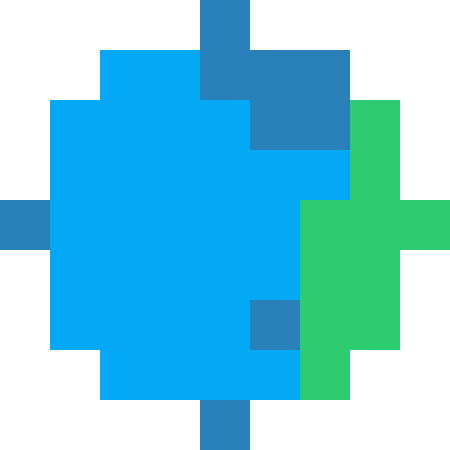
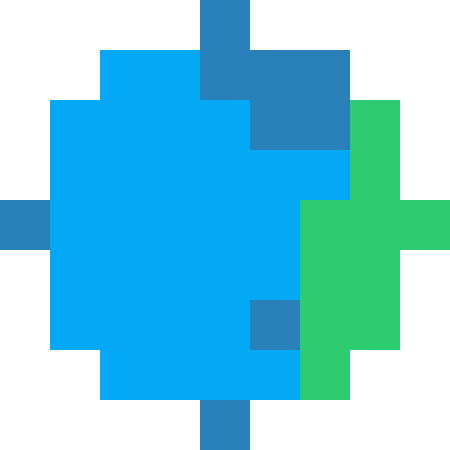
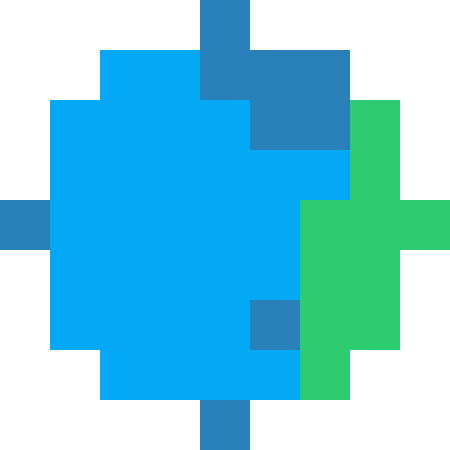
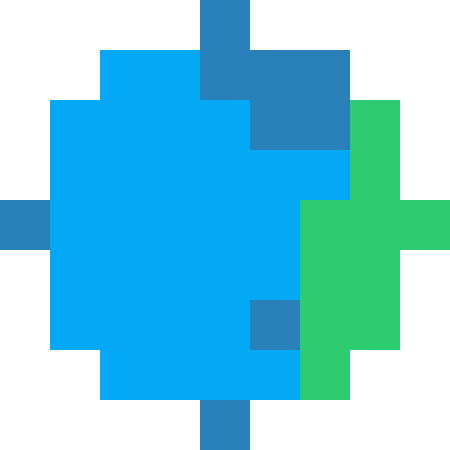
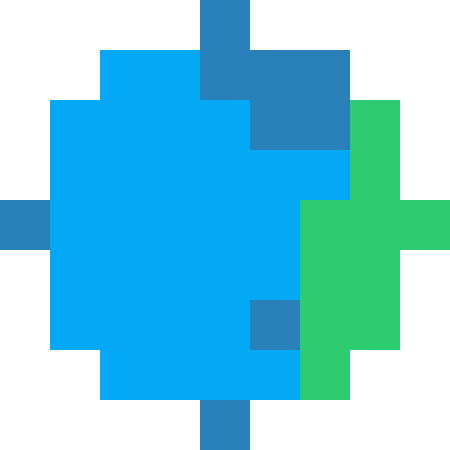
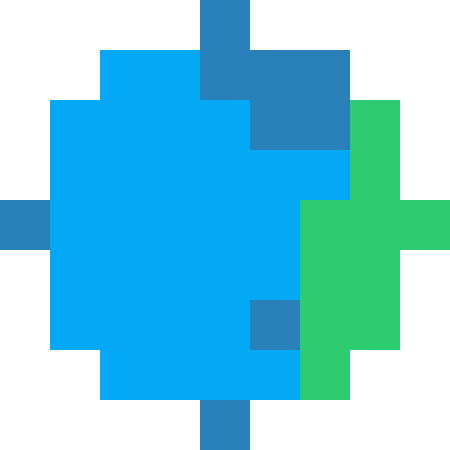
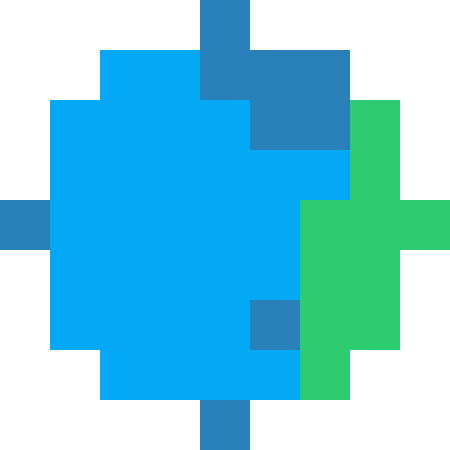
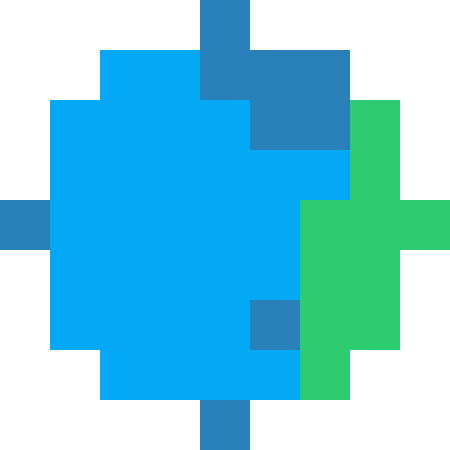
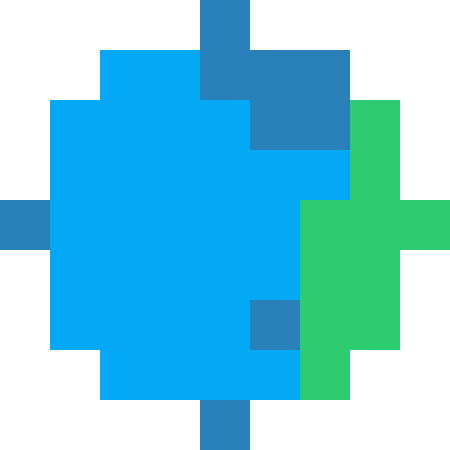
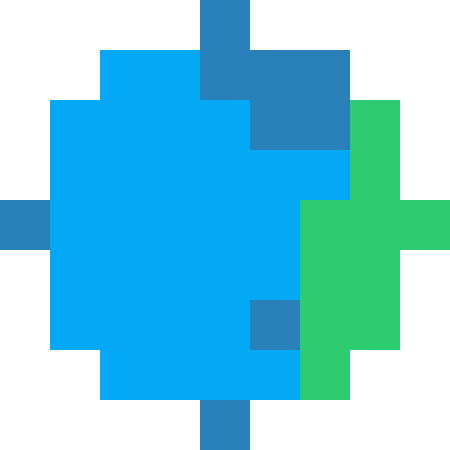
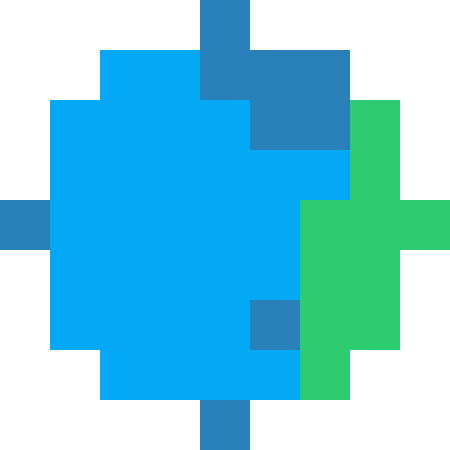
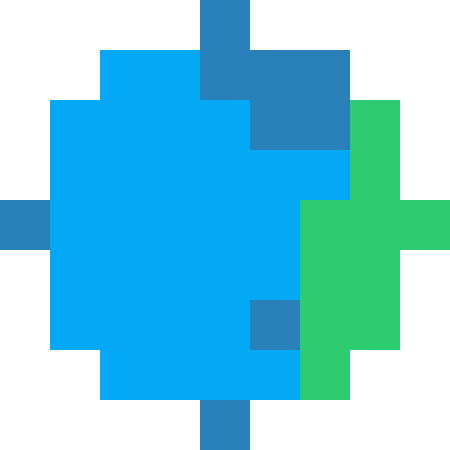
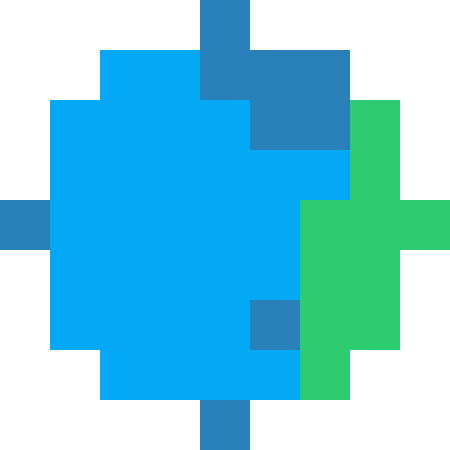

In [29]:
### @doc runSimulation
# runs the environment
# @param  {Function} filterFunction: defines the shape of the environment
# @param  {Vector}   leftBottomCorner: defines the start of the environment
# @param  {Vector}   rightTopCorner: defines the end of the environment
# @param  {Int}      iterations: number of iterations to run the environment
# @return {[Agent]}  population: the population after runing the environment

pictures = []
def runSimulation(filterFunction, leftBottomCorner, rightTopCorner, iterations, evaluationStrategy = globalEvaluationStrategy):
    points = getAvailablePoints(leftBottomCorner, rightTopCorner, filterFunction)
    population = populateGrid(points) # appends the strategies
    graphPopulation(population)
    for i in range(iterations):
        population = newGeneration(population, evaluationStrategy)
        pictures.append(graphPopulation(population))
    
    return population

# Testing runSimulation
#for agent in runSimulation(fiveCircleFilterFunction, (-5, -5), (5, 5), 2):
    #print(agent.position, agent.strategy)
runSimulation(fiveCircleFilterFunction, (-5, -5), (5, 5), 20)
anim = makeAnimation(pictures, 20)
#drawReferences()
display_animation(anim)